# Apple Quality Analysis — PCA & Hierarchical Clustering

**Short summary**  
This notebook presents an analytical study of apple quality using **Principal Component Analysis (PCA)** and **Hierarchical Agglomerative Clustering (HAC)**. The objective is to identify meaningful groups of apples based on their physical and sensory characteristics and to evaluate how these groups relate to the existing quality labels.

**What this notebook contains**  
- Data loading and cleaning  
- Exploratory data summary and preprocessing  
- PCA for dimensionality reduction and visualization  
- Hierarchical clustering on PCA scores 
- Cluster evaluation and interpretation  

**Context and objective**  
The dataset provides apple measurements along with a predefined “good” or “bad” quality label. However, the results of the PCA and HAC analyses reveal that these binary labels may not fully capture the natural variability in apple characteristics.  

The clusters obtained suggest a **continuous spectrum of quality** rather than a strict separation between good and bad apples. Each group displays a unique combination of features such as sweetness, acidity, crunchiness, and ripeness, forming **intermediate quality levels** instead of two distinct classes.  

This observation calls into question the reliability of the initial labeling, as it likely simplifies a more complex quality structure. Such overlap between groups can make it difficult to train accurate classification models based solely on these labels.  

By contrast, PCA and HAC allow for a **data-driven segmentation**, uncovering hidden patterns in the dataset. These techniques highlight that apple quality is multidimensional and better represented by clusters reflecting **gradual differences** in taste, texture, and ripeness rather than a binary judgment.

---

> Tip: For a quick overview, run the top sections (Data → PCA → Clustering) in order; all plotting cells are ready for export for presentations.

In [23]:
# --- Libraries Importation ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. Load dataset

We load the `apple_quality.csv` dataset and preview the first rows. The dataset contains measurements of physical and sensory attributes for apples along with a `Quality` label. All subsequent processing assumes the dataset is available in `df`.

In [24]:
# --- Load Dataset from GitHub ---
# Dataset: Apple Quality
path = "../dataset/apple_quality.csv"
df = pd.read_csv(path)

# Preview the first few rows
df.head()


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


## 2. Dataset summary and initial checks

- Display dataset dimensions and column types
- Convert non-numeric columns where appropriate (`Acidity`) to numeric values
- Check for missing values and duplicates


In [25]:
# --- Dataset Basic Information ---
print("Dataset Shape:", df.shape)
print("\nColumn Data Types:\n", df.dtypes)

# Convert 'Acidity' column to numerical
df['Acidity'] = pd.to_numeric(df['Acidity'], errors='coerce')

print("\nData Types After Conversion:\n", df.dtypes)


Dataset Shape: (4001, 9)

Column Data Types:
 A_id           float64
Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity         object
Quality         object
dtype: object

Data Types After Conversion:
 A_id           float64
Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity        float64
Quality         object
dtype: object


## 3. Feature engineering

Purpose: create a clean feature matrix ready for analysis and modelling. Key steps performed in the code cell below:

- One‑hot encode the `Quality` target into `Quality_good` and `Quality_bad` for downstream analysis and reporting.
- Remove identifier columns (e.g., `A_id`) and any redundant fields not used for clustering/PCA.
- Construct `data` as the feature matrix used throughout the notebook.

Note: all transformations are deterministic so results are reproducible.

In [26]:
# --- One-Hot Encoding for 'Quality' Column ---
quality_column = df['Quality']

# Create a new dataframe for Quality and encode it (target)
df_quality = pd.DataFrame(quality_column, columns=['Quality'])
df_quality_encoded = pd.get_dummies(df_quality)

#data = pd.concat([df, df_quality_encoded], axis=1)
data = df.drop(columns=['Quality', 'A_id'])

# Preview the processed dataset
data.head()


,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984


## 4. Data cleaning

Actions executed:

- Checked for missing values and duplicate rows; removed rows with missing numeric data.
- Confirmed final sample size and feature count (n=4000, p=9 after encoding).
- Verified that the dataset is balanced with respect to `Quality_good`/`Quality_bad`.

In [27]:
# --- Cleaning Process ---
# 1. Check for NaN values in each column
print("Number of NaN values per column:")
print(data.isna().sum())

# 2. Count total NaN values in the dataset
total_nan = data.isna().sum().sum()
print(f"\nTotal NaN values in the dataset: {total_nan}")

# 3. Drop rows containing NaN values
data_cleaned = data.dropna()

# 4. Show new dimensions after cleaning
print(f"\nShape after cleaning: {data_cleaned.shape}")

# 5. Verify if any NaN remain
print("Any NaN left?", data_cleaned.isna().sum().sum())

# 6. Verify duplications in the dataset
print("duplications : ", data_cleaned.duplicated().sum())

# 6. Preview cleaned dataset
data_cleaned.head()


Number of NaN values per column:
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        1
dtype: int64

Total NaN values in the dataset: 7

Shape after cleaning: (4000, 7)
Any NaN left? 0
duplications :  0


,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984


## 5. Dataset description

- `n` = number of samples (observations)
- `p` = number of features (columns)

In [28]:
# --- Dataset Description After Cleaning ---
n = data_cleaned.shape[0]  # number of rows (samples)
p = data_cleaned.shape[1]  # number of columns (features)

print(f"Dataset dimensions: {n} rows x {p} columns\n")

# Display descriptive statistics for all columns
print(data_cleaned.describe(include='all'))


Dataset dimensions: 4000 rows x 7 columns

              Size       Weight    Sweetness  Crunchiness    Juiciness  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     -0.503015    -0.989547    -0.470479     0.985478     0.512118   
std       1.928059     1.602507     1.943441     1.402757     1.930286   
min      -7.151703    -7.149848    -6.894485    -6.055058    -5.961897   
25%      -1.816765    -2.011770    -1.738425     0.062764    -0.801286   
50%      -0.513703    -0.984736    -0.504758     0.998249     0.534219   
75%       0.805526     0.030976     0.801922     1.894234     1.835976   
max       6.406367     5.790714     6.374916     7.619852     7.364403   

          Ripeness      Acidity  
count  4000.000000  4000.000000  
mean      0.498277     0.076877  
std       1.874427     2.110270  
min      -5.864599    -7.010538  
25%      -0.771677    -1.377424  
50%       0.503445     0.022609  
75%       1.766212     1.510493  
max       7.237837

## Data Summary and Observations

The cleaned and preprocessed dataset contains **4000 samples** and **9 columns**, including 7 numerical features and 2 categorical indicators (`Quality_good`, `Quality_bad`).

###  General Observations
1. **Feature Scaling:**  
   - Numerical features such as `Size`, `Weight`, `Sweetness`, `Crunchiness`, `Juiciness`, `Ripeness`, and `Acidity` show both negative and positive values.  
   - This suggests that the dataset was **standardized** before.  
  
2. **Feature Variability:**  
   - All continuous features have standard deviations around **1.4–2.1**, confirming they are scaled but still contain natural variability.  
   - The range (min to max) for most variables is roughly **-7 to +7**, typical for standardized data.




## 6. Principal Component Analysis (PCA)

Objective: reduce dimensionality to simplify visualization and capture the main sources of variance.

- Standardize numeric features before PCA.
- Fit PCA and display explained variance per component.
- Retain the first four components which explain ~72% of the variance for visualization and clustering experiments.

In [29]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# PCA
acp = PCA()
coord = acp.fit_transform(data_scaled)

# Explained variance
valprop = acp.explained_variance_
inert = acp.explained_variance_ratio_ * 100
cuminert = np.cumsum(acp.explained_variance_ratio_) * 100

# Display table
pd.DataFrame({
    'valprop': valprop,
    'inertie': inert,
    'inertiecum': cuminert
})


,valprop,inertie,inertiecum
0,1.513372,21.614201,21.614201
1,1.460681,20.861653,42.475855
2,1.256649,17.947635,60.423490
3,1.146197,16.370152,76.793642
4,0.708229,10.115033,86.908675
5,0.609604,8.706457,95.615133
6,0.307017,4.384867,100.000000


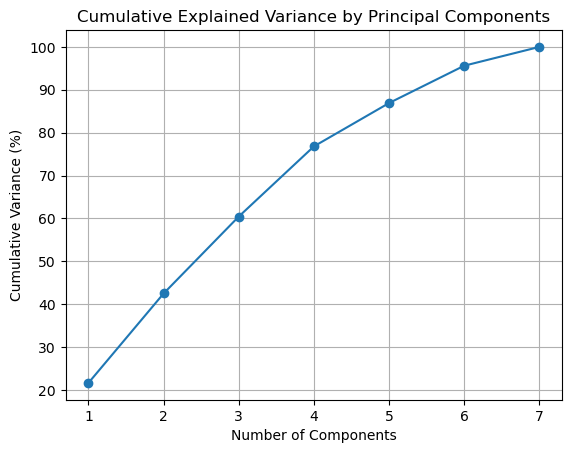

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(cuminert) + 1), cuminert, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.grid(True)
plt.show()


### Choice of the number of components

We chose to retain the first **four principal components** because they explain approximately **77% of the total variance**.  
This level of explained variance indicates that these components capture most of the relevant information in the dataset while significantly reducing dimensionality.  
Beyond the fourth component, the additional variance explained becomes marginal, which justifies limiting the analysis to the first four axes.


## PCA Components and Explained Variance

We first calculate the principal components of the dataset.  
This allows us to reduce dimensionality while retaining most of the information.  
The eigenvectors (`components_`) represent the directions of maximum variance,
and the eigenvalues indicate the amount of variance captured by each component.


In [31]:
vectprop = acp.components_
print(vectprop)

[[-1.84201414e-01 -4.90239753e-02 -3.43647817e-01 -1.64390747e-01
  -3.55178211e-01  6.10479025e-01 -5.65430939e-01]
 [ 6.21422344e-01 -7.95516116e-02 -4.73019888e-01  5.10571126e-01
  -3.33445797e-01 -5.38542674e-02  9.48089711e-02]
 [-3.24291394e-01  5.21674984e-01  1.92047559e-01  3.23291942e-01
  -5.14203413e-01 -3.92344514e-01 -2.50900358e-01]
 [ 9.78734269e-02  7.06248515e-01 -5.20301237e-01 -3.97831397e-01
   1.94331809e-01 -6.95690961e-02  1.41583610e-01]
 [-3.97996955e-01  1.20340798e-01 -4.73319742e-02  2.52420409e-01
  -1.92303735e-01  4.73767911e-01  7.06911152e-01]
 [-3.41732057e-01  2.65311037e-02 -3.12445925e-01  5.81330121e-01
   6.16920176e-01  1.44138487e-05 -2.57599752e-01]
 [ 4.35864220e-01  4.52935570e-01  5.00699459e-01  2.18733935e-01
   2.07174101e-01  4.91105860e-01 -1.49067751e-01]]


## 7. Individual and variable contributions

We compute:

- Contribution (Ctr) and representation quality (cos²) for each individual on principal components.
- Variable correlations with principal components and their contributions.

These tables help interpret which features drive each principal component and how well samples are represented in the reduced space.

In [32]:
A = coord**2
normind = np.sum(data_scaled**2, axis=1)

# Contribution of individuals
Ctr1 = (A[:,0] / (n*valprop[0])) * 100
Ctr2 = (A[:,1] / (n*valprop[1])) * 100
Ctr3 = (A[:,2] / (n*valprop[2])) * 100
Ctr4 = (A[:,3] / (n*valprop[3])) * 100

# Quality of representation
Cos1 = (A[:,0] / normind) * 100
Cos2 = (A[:,1] / normind) * 100
Cos3 = (A[:,2] / normind) * 100
Cos4 = (A[:,3] / normind) * 100

# Display table
pd.DataFrame({
    'ID': data_cleaned.index,
    'Contr_1': Ctr1, 'Contr_2': Ctr2, 'Contr_3': Ctr3, 'Contr_4': Ctr4,
    'Coscar_1': Cos1, 'Coscar_2': Cos2, 'Coscar_3': Cos3, 'Coscar_4': Cos4
})


,ID,Contr_1,Contr_2,Contr_3,Contr_4,Coscar_1,Coscar_2,Coscar_3,Coscar_4
0,0,0.005264,0.202067,0.000050,0.065719,2.031762,75.276363,0.016153,19.211427
1,1,0.002740,0.017940,0.000003,0.101901,2.597370,16.410967,0.002011,73.146801
2,2,0.013799,0.002231,0.038707,0.021481,19.094260,2.979308,44.473669,22.511643
3,3,0.078317,0.025183,0.006294,0.001241,51.580841,16.008291,3.442245,0.618939
4,4,0.022548,0.001842,0.024271,0.011366,28.153723,2.219917,25.164304,10.748431
...,...,...,...,...,...,...,...,...,...
3995,3995,0.013876,0.004917,0.030952,0.024826,19.745631,6.753419,36.573031,26.756793
3996,3996,0.012497,0.004721,0.013499,0.072629,12.147643,4.429373,10.895457,53.469491
3997,3997,0.071660,0.009565,0.042437,0.000130,47.095520,6.067023,23.158512,0.064495
3998,3998,0.000789,0.115100,0.001087,0.018762,0.572322,80.608543,0.655084,10.310909


## Contribution and Representation Quality of Variables

For each variable, we calculate:
- `corvar`: correlation with each principal component.
- `Ctrvar`: contribution to component's inertia.
- `Cosvar`: quality of representation (cos²) on the component.


In [33]:
sqrt_eigval = np.sqrt(valprop)

corvar1 = acp.components_[0,:] * sqrt_eigval[0]
corvar2 = acp.components_[1,:] * sqrt_eigval[1]
corvar3 = acp.components_[2,:] * sqrt_eigval[2]
corvar4 = acp.components_[3,:] * sqrt_eigval[3]

Ctrvar1 = (corvar1**2 / valprop[0]) * 100
Ctrvar2 = (corvar2**2 / valprop[1]) * 100
Ctrvar3 = (corvar3**2 / valprop[2]) * 100
Ctrvar4 = (corvar4**2 / valprop[3]) * 100

Cosvar1 = corvar1**2 * 100
Cosvar2 = corvar2**2 * 100
Cosvar3 = corvar3**2 * 100
Cosvar4 = corvar4**2 * 100

pd.DataFrame({
    'Variable': data_cleaned.columns,
    'corvar1': corvar1, 'corvar2': corvar2, 'corvar3': corvar3, 'corvar4': corvar4,
    'Ctrvar1': Ctrvar1, 'Ctrvar2': Ctrvar2, 'Ctrvar3': Ctrvar3, 'Ctrvar4': Ctrvar4,
    'Cosvar1': Cosvar1, 'Cosvar2': Cosvar2, 'Cosvar3': Cosvar3, 'Cosvar4': Cosvar4
})


,Variable,corvar1,corvar2,corvar3,corvar4,Ctrvar1,Ctrvar2,Ctrvar3,Ctrvar4,Cosvar1,Cosvar2,Cosvar3,Cosvar4
0,Size,-0.226603,0.751043,-0.363532,0.104784,3.393016,38.616573,10.516491,0.957921,5.134897,56.406491,13.215534,1.097966
1,Weight,-0.060309,-0.096145,0.584799,0.756114,0.240335,0.632846,27.214479,49.878696,0.363716,0.924386,34.199037,57.170823
2,Sweetness,-0.422753,-0.571685,0.215286,-0.557038,11.809382,22.374781,3.688227,27.071338,17.871994,32.682416,4.634805,31.029092
3,Crunchiness,-0.202232,0.617069,0.362411,-0.425921,2.702432,26.068287,10.451768,15.826982,4.089786,38.077450,13.134200,18.140843
4,Juiciness,-0.436937,-0.402998,-0.576424,0.208053,12.615156,11.118610,26.440515,3.776485,19.091430,16.240741,33.226437,4.328597
5,Ripeness,0.751006,-0.065088,-0.439820,-0.074481,37.268464,0.290028,15.393422,0.483986,56.401067,0.423639,19.344122,0.554743
6,Acidity,-0.695589,0.114585,-0.281260,0.151580,31.971215,0.898874,6.295099,2.004592,48.384355,1.312968,7.910727,2.297658


## Individuals Plot (Axe1 vs Axe2)

Position of each individual on the first two principal components.


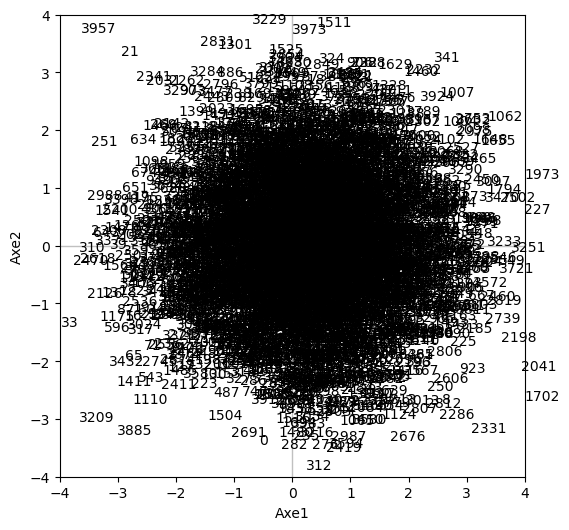

In [34]:
fig, axes = plt.subplots(figsize=(6,6))
axes.set_xlim(-4,4)
axes.set_ylim(-4,4)

for i in range(n):
    axes.annotate(data_cleaned.index[i], (coord[i,0], coord[i,1]))

axes.plot([-4,4],[0,0], color='silver', linestyle='-', linewidth=1)
axes.plot([0,0],[-4,4], color='silver', linestyle='-', linewidth=1)
axes.set_xlabel('Axe1')
axes.set_ylabel('Axe2')
plt.show()


## Correlation Circle (Variables on Axe1 vs Axe2)

Shows how variables correlate with the first two principal components.


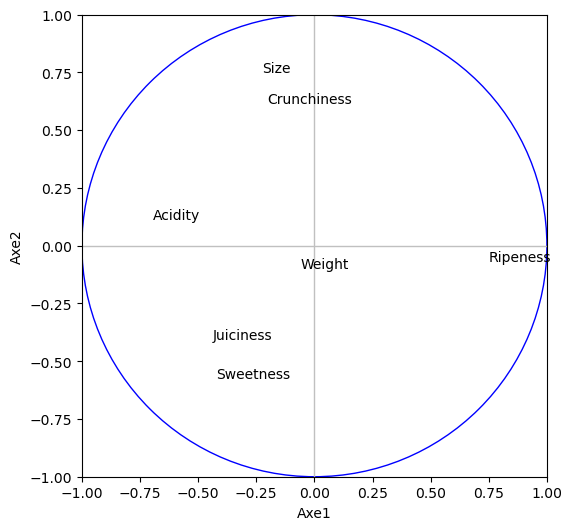

In [35]:
fig, axes = plt.subplots(figsize=(6,6))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

for j in range(p):
    axes.annotate(data_cleaned.columns[j], (corvar1[j], corvar2[j]))

axes.plot([-1,1],[0,0], color='silver', linestyle='-', linewidth=1)
axes.plot([0,0],[-1,1], color='silver', linestyle='-', linewidth=1)

circle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(circle)
axes.set_xlabel('Axe1')
axes.set_ylabel('Axe2')
plt.show()


## PCA Analysis – First two Components
---

### **Component 1 (Axe 1) – Ripeness & Flavor Gradient**
- **Main contributors:**  
  - `Ripeness` (~37%)  
  - `Acidity` (~32%)  
  - `Juiciness` (~19%)  
  - `Sweetness` (~18%)  

- **Interpretation:**  
  - Captures the **ripeness and flavor profile** of apples.  
  - Higher `Ripeness` combined with lower `Acidity` corresponds to sweeter, juicier apples.  
  - Explains the **largest variation** in the dataset and may partially align with perceived quality (post-hoc analysis).

---

### **Component 2 (Axe 2) – Physical & Textural Properties**
- **Main contributors:**  
  - `Size` (~39%)  
  - `Crunchiness` (~38%)  
  - `Weight` (~27%)  

- **Interpretation:**  
  - Represents **physical structure and texture** of apples.  
  - Orthogonal to Component 1, providing an **independent perspective** on size and crunchiness traits.


## Individuals and Correlation Circle (Axe3 vs Axe4)

We repeat the plotting for the 3rd and 4th components.


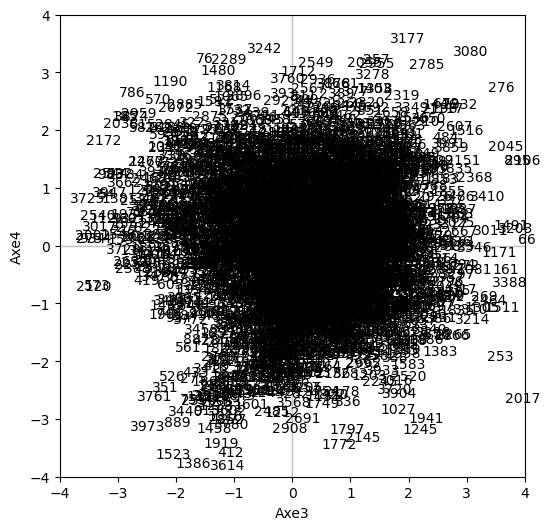

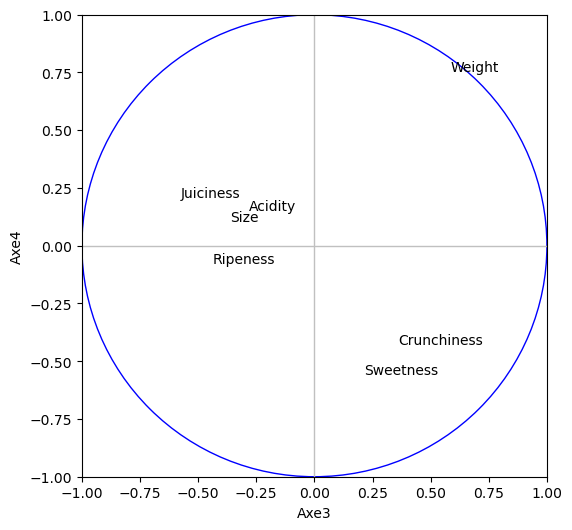

In [36]:
# Individuals plot Axe3 vs Axe4
fig, axes = plt.subplots(figsize=(6,6))
axes.set_xlim(-4,4)
axes.set_ylim(-4,4)
for i in range(n):
    axes.annotate(data_cleaned.index[i], (coord[i,2], coord[i,3]))
axes.plot([-4,4],[0,0], color='silver', linestyle='-', linewidth=1)
axes.plot([0,0],[-4,4], color='silver', linestyle='-', linewidth=1)
axes.set_xlabel('Axe3')
axes.set_ylabel('Axe4')
plt.show()

# Correlation circle Axe3 vs Axe4
fig, axes = plt.subplots(figsize=(6,6))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
for j in range(p):
    axes.annotate(data_cleaned.columns[j], (corvar3[j], corvar4[j]))
axes.plot([-1,1],[0,0], color='silver', linestyle='-', linewidth=1)
axes.plot([0,0],[-1,1], color='silver', linestyle='-', linewidth=1)
circle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(circle)
axes.set_xlabel('Axe3')
axes.set_ylabel('Axe4')
plt.show()


## PCA Analysis – Second two Components
---
### **Component 3 (Axe 3) – Sweetness & Juiciness Contrast**
- **Main contributors:**  
  - `Juiciness` (~33%)  
  - `Sweetness` (~31%)  
  - `Acidity` (~8%)  

- **Interpretation:**  
  - Highlights differences between **taste-related characteristics**.  
  - Captures subtler variations in flavor profile not explained by Components 1 and 2.

---

### **Component 4 (Axe 4) – Weight & Physical Balance**
- **Main contributors:**  
  - `Weight` (~50%)  
  - `Size` (~10%)  
  - `Crunchiness` (~18%)  

- **Interpretation:**  
  - Focuses on **weight and structural balance** of apples.  
  - Explains minor variance; may indicate differences in density or firmness.

---

### **Summary of Variance**
| Component | Main Drivers | Interpretation |
|-----------|--------------|----------------|
| Axe1      | Ripeness, Acidity, Juiciness, Sweetness | Captures **ripeness and flavor gradient** |
| Axe2      | Size, Crunchiness, Weight | Represents **physical structure and texture** |
| Axe3      | Juiciness, Sweetness, Acidity | Highlights **taste & sensory differences** |
| Axe4      | Weight, Crunchiness, Size | Reflects **weight, structural balance & minor textural variations** |

**Key takeaway:**  
- The **first four components explain ~77% of the variance**, providing a **concise summary of apple physical traits, ripeness, and sensory characteristics**.  
- **Axe1 and Axe2** are the most informative for **visualizing major apple characteristics**, while **Axe3 and Axe4** refine the description with **subtle taste and acidity variations**.




## 8. Hierarchical Clustering (HAC)

**Objective:** Identify natural groupings of apples based on all measured characteristics to reveal underlying patterns and assess how these clusters relate to apple quality.

---


1. **Clustering performed on PCA projected dataset**

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Reduce to 4 components for visualization and clustering
pca = PCA(n_components=4)
data_pca = pca.fit_transform(data_scaled)
Z_pca = linkage(data_pca, method='ward', metric='euclidean')

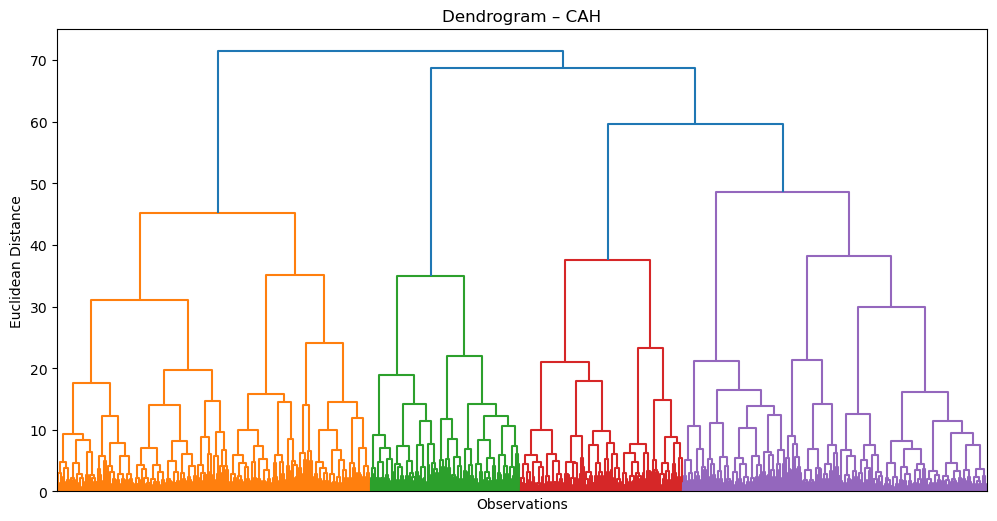

In [38]:
# Plot dendrogram
plt.figure(figsize=(12,6))
plt.title("Dendrogram – CAH")
dendrogram(Z_pca, no_labels=True, color_threshold=50)
plt.xlabel("Observations")
plt.ylabel("Euclidean Distance")
plt.show()


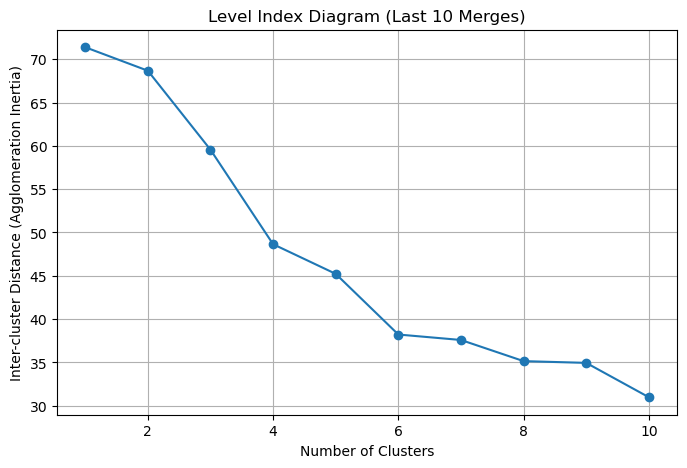

In [39]:
# Extract linkage distances
last = Z_pca[:, 2]

# Keep only the last 10 steps
last_10 = last[-10:]
num_clusters = range(1, 11)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(num_clusters, last_10[::-1], marker='o')
plt.title("Level Index Diagram (Last 10 Merges)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inter-cluster Distance (Agglomeration Inertia)")
plt.grid(True)

plt.show()


### **Choice of the Number of Clusters – Level Index Diagram**

The **level index diagram** (inertia plot) shows a clear change in slope around **four clusters**.  
Beyond this point, the increase in inter-cluster distance becomes more gradual, indicating that  
further merging combines clusters that are too dissimilar.

**→ Optimal number of clusters: 4**

This choice balances **compactness within clusters** and **separation between clusters**.


In [40]:
# Extract cluster labels by cutting dendrogram
groupes_cah = fcluster(Z_pca, t=50, criterion='distance')

# Index sorted by cluster
idg = np.argsort(groupes_cah)

# Display observations with cluster labels
clustered_df = pd.DataFrame({
    'Observation': data_cleaned.index[idg],
    'Cluster': groupes_cah[idg]
})
clustered_df


,Observation,Cluster
0,1720,1
1,1517,1
2,2761,1
3,2763,1
4,2764,1
...,...,...
3995,999,4
3996,2672,4
3997,2671,4
3998,1041,4


## Cluster Analysis and Interpretation of Results

**Objective:** Analyze the characteristics of each cluster obtained from the hierarchical clustering of apple features, and interpret their differences based on physical and sensory attributes.

---

### 1. Cluster Counts
| Cluster | Number of Apples |
|----------|------------------|
| 1        | 1351             |
| 2        | 643              |
| 3        | 698              |
| 4        | 1308             |

**Interpretation:**  
The clusters show a fairly balanced distribution of apples. Clusters 1 and 4 contain the largest proportions, while Cluster 2 is the smallest group, possibly representing a more specific apple profile.

---

### 2. Mean Feature Values by Cluster
| Feature        | Cluster 1 | Cluster 2 | Cluster 3 | Cluster 4 |
|----------------|-----------|-----------|-----------|-----------|
| **Size**       | 0.404     | 0.570     | -2.229    | -1.046    |
| **Weight**     | -0.581    | -1.445    | 0.402     | -1.930    |
| **Sweetness**  | -1.349    | -1.096    | 0.640     | 0.152     |
| **Crunchiness**| 1.812     | -0.127    | 0.386     | 0.999     |
| **Juiciness**  | -0.636    | 2.665     | 0.904     | 0.431     |
| **Ripeness**   | 0.051     | 0.162     | -0.389    | 1.599     |
| **Acidity**    | 0.020     | 2.100     | -0.420    | -0.594     |

---

### 3. Cluster Profiles and Interpretations

- **Cluster 1:**  
  Apples in this group are **crunchy** and **moderately ripe**, with average size and weight.  
  The combination of **high crunchiness** and **balanced ripeness** suggests good texture and freshness.

- **Cluster 2:**  
  Characterized by **high juiciness** and **strong acidity**, but **low sweetness** and **small size**.  
  These apples are likely **overripe or of lower sensory quality**, showing extreme juiciness and sourness.

- **Cluster 3:**  
  Small apples with **high sweetness and juiciness**, showing moderate crunchiness and balanced acidity.  
  These characteristics indicate **pleasant-tasting apples** that are likely appreciated by consumers.

- **Cluster 4:**  
  Apples that are **very ripe**, with **low acidity** and **moderate juiciness**.  
  Their **light weight** and **mild flavor** profile make them less fresh but not necessarily bad in quality.

---

### 4. General Insights
- The clusters successfully differentiate apples according to **size, sweetness, ripeness, and acidity**.  
- **Clusters 1 and 3** show desirable traits (crunchy, sweet, juicy).  
- **Cluster 2** reflects apples with **extreme acidity and juiciness**, which may indicate poor storage or over-ripeness.  
- **Cluster 4** contains **very ripe and light apples**, forming a distinct maturity group.

**Conclusion:**  
The clustering highlights clear differences between apple groups. The results can be used to improve **quality control**, optimize **harvest timing**, and better understand **consumer-preferred profiles** based on sensory characteristics.


### **Clusters Visualisation on the PCA First Factorial Plane**




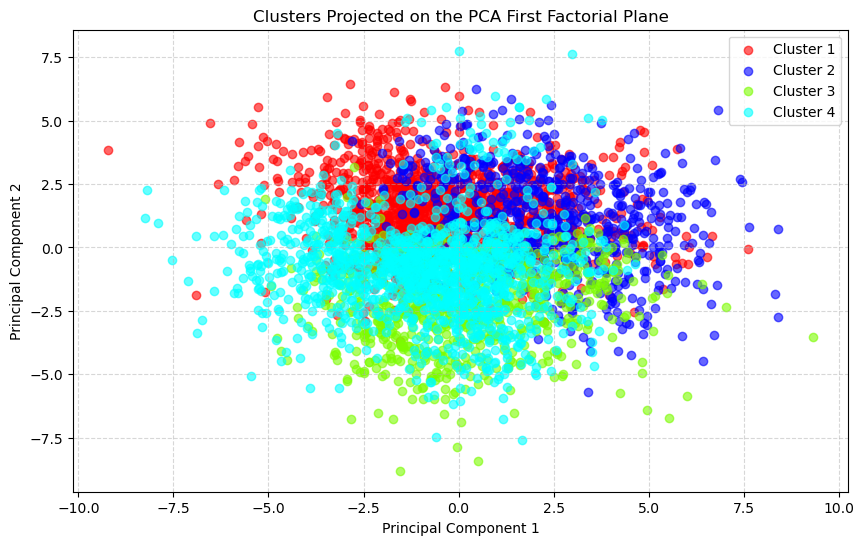

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA on the cleaned dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_cleaned)

# Plot clusters on the first factorial plane
plt.figure(figsize=(10, 6))
plt.title("Clusters Projected on the PCA First Factorial Plane")

# Define colors for clusters
colors = ['red', 'blue', 'lawngreen', 'aqua']

# Scatter points by cluster
for color, k in zip(colors, np.unique(groupes_cah)):
    plt.scatter(
        X_pca[groupes_cah == k, 0],
        X_pca[groupes_cah == k, 1],
        c=color,
        label=f'Cluster {k}',
        alpha=0.6
    )


plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [42]:
print(quality_column.isna().sum())
quality_column = quality_column.dropna()
print(quality_column.isna().sum())

# Ensure 'Quality' and cluster arrays have matching indices
#quality_column = df['Quality'].dropna()

# Create a DataFrame combining cluster labels and quality
quality_clusters = pd.DataFrame({
    'Cluster': groupes_cah[:len(quality_column)],
    'Quality': quality_column.values
})

# Compute counts of 'good' and 'bad' per cluster
cluster_quality_counts = quality_clusters.groupby(['Cluster', 'Quality']).size().unstack(fill_value=0)

# Compute percentages within each cluster
cluster_quality_percent = (cluster_quality_counts.T / cluster_quality_counts.sum(axis=1)).T * 100

# Display percentages (rounded)
print(cluster_quality_percent.round(2))


1
0
Quality    bad   good
Cluster              
1        55.59  44.41
2        47.74  52.26
3        38.25  61.75
4        51.30  48.70


### **Cluster–Quality Relationship Analysis**
---

| Cluster | % Bad | % Good |
|:--------:|:------:|:------:|
| **1** | 55.59 | 44.41 |
| **2** | 47.74 | 52.26 |
| **3** | 38.25 | 61.75 |
| **4** | 51.30 | 48.70 |

---

### **Interpretation**
- The distribution of quality across clusters shows **no extreme imbalance**, meaning the clustering structure is not dominated by the “Quality” variable alone.  
- **Cluster 3** has the **highest proportion of good apples (≈ 62%)**, indicating that this group likely represents apples with **favorable physical and sensory characteristics**.  
- **Cluster 1** has the **highest proportion of bad apples (≈ 56%)**, suggesting that its features may be associated with **lower sweetness, juiciness, or ripeness**.  
- **Clusters 2 and 4** have **balanced proportions** (around 50%), reflecting **intermediate quality groups** with mixed apple characteristics.

---

## Cluster Analysis and Interpretation of Results

The results show that the **quality labels (“good” and “bad”)** do not align strongly with the clustering structure.  
Each cluster contains both categories in fairly similar proportions, suggesting that the **initial labeling may not have been based on consistent or relevant criteria**.

This overlap makes it difficult for any **supervised classification model** to clearly separate good and bad apples, since the boundary between both classes is not well-defined in the feature space.

Instead, the **unsupervised PCA + CAH approach** provides a more objective segmentation of apples based purely on their measurable characteristics — such as size, sweetness, ripeness, and acidity — without relying on possibly biased labels.

---

### Cluster Profiles Suggested

| Cluster | Main Traits | Suggested Name
|----------|--------------|----------------
| **1** | Crunchy, moderately ripe, balanced texture | **"Crispy Fresh"**
| **2** | Highly juicy, acidic, low sweetness | **"Sour Juicy"**
| **3** | Small, sweet, juicy, pleasant texture | **"Sweet Premium"**
| **4** | Very ripe, light, low acidity | **"Mature Mild"**

---

### Key Takeaways
- The **PCA** effectively reduced the feature space, revealing the dominant sources of variance related to apple texture, sweetness, and ripeness.  
- The **HAC** then grouped apples into **four coherent clusters**, each representing a distinct sensory or physical profile.  
- The weak alignment between clusters and the initial “good/bad” labels questions the **reliability of the default quality classification**, indicating potential subjectivity or insufficient feature-based labeling.  
- Consequently, **unsupervised clustering provides a more meaningful quality segmentation**, which could serve as a **foundation for redefining apple quality labels** or training more robust classification models in the future.

---

**Conclusion:**  
The PCA–HAC pipeline reveals that apple quality cannot be reduced to a simple “good vs bad” dichotomy.  
Instead, apples form **natural groups** with overlapping characteristics, highlighting the need for **data-driven labeling**.  
The proposed cluster-based segmentation (Crispy Fresh, Sour Juicy, Sweet Premium, and Mature Mild) offers a more nuanced and objective way to describe apple quality profiles.

